In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance


In [2]:
def generate_periods(start_date, end_date, increment_days=10):
    periods = []
    current_end_date = start_date + timedelta(days=365)
    while current_end_date <= end_date:
        periods.append((start_date.strftime('%Y-%m-%d'), current_end_date.strftime('%Y-%m-%d')))
        current_end_date += timedelta(days=increment_days)
    return periods

In [3]:
def eval_periods(df_list, features, n_clusters):
    scaler = StandardScaler()
    ari_scores = []
    ks_p_values = {feature: [] for feature in features}
    for i, df in enumerate(df_list):
        if i == 0:
            X_scaled = scaler.fit_transform(df[features])
            initial_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            initial_kmeans.fit(X_scaled)
            continue
        X_current = scaler.transform(df[features])
        kmeans_current = KMeans(n_clusters=n_clusters, random_state=42)
        current_clusters = kmeans_current.fit_predict(X_current)
        initial_clusters = initial_kmeans.predict(X_current)
        ari = adjusted_rand_score(initial_clusters, current_clusters)
        ari_scores.append((i, ari))
        current_features = df.groupby(current_clusters).mean()
        initial_features = df.groupby(initial_clusters).mean()
        for feature in features:
            _, p_value = ks_2samp(initial_features[feature], current_features[feature])
            ks_p_values[feature].append(p_value)
    for period_index, ari in ari_scores:
        print(f"Période {period_index}: ARI = {ari}")
    return ari_scores, ks_p_values   

In [4]:
def plot(ari_scores, ks_p_values):
    periods, ari_values = zip(*ari_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(periods, ari_values, marker='o', linestyle='-', color='b')
    plt.title("ARI Scores over Time Periods")
    plt.xlabel("Periods")
    plt.ylabel("ARI Score")
    plt.grid(True)
    plt.show()
    for feature, p_values in ks_p_values.items():
        plt.figure(figsize=(10, 6))
        plt.plot(periods, p_values, marker='o', linestyle='-', label=f'{feature} p-values')
        plt.title(f"KS Test P-Values for {feature} over Time Periods")
        plt.xlabel("Periods")
        plt.ylabel("P-Value")
        plt.axhline(0.05, color='r', linestyle='--', label='0.05 significance level')
        plt.legend()
        plt.grid(True)
        plt.show()

In [5]:
conn = sqlite3.connect('olist.db')
cursor = conn.cursor()
start_date = datetime(2016, 9, 4)
end_date = datetime(2018, 10, 17)
data_list = []

In [6]:
periods = generate_periods(start_date, end_date)

In [7]:
for period_start, period_end in periods:
    query = f"""
    WITH 
        review_scores AS (
        SELECT
            c.customer_unique_id,
            AVG(r.review_score) AS average_review_score
        FROM
            orders o
            JOIN order_reviews r ON o.order_id = r.order_id 
            JOIN customers c ON o.customer_id = c.customer_id
        WHERE
            o.order_purchase_timestamp >= '{period_start}'
            AND o.order_purchase_timestamp <= '{period_end}'
        GROUP BY
            c.customer_unique_id
        ),
        seller_count AS (
        SELECT
            c.customer_unique_id,
            COUNT(DISTINCT i.seller_id) AS nb_of_different_sellers
        FROM
            orders o
            JOIN order_items i ON o.order_id = i.order_id
            JOIN customers c ON o.customer_id = c.customer_id
        WHERE
            o.order_purchase_timestamp >= '{period_start}'
            AND o.order_purchase_timestamp <= '{period_end}'
        GROUP BY
            c.customer_unique_id
        ),
        rfm AS (
        SELECT
            c.customer_unique_id,
            MAX(o.order_purchase_timestamp) AS last_order_date,
            COUNT(o.order_id) AS frequency,
            SUM(i.price) AS monetary
        FROM
            orders o
            JOIN order_items i ON o.order_id = i.order_id
            JOIN customers c ON o.customer_id = c.customer_id
        WHERE
            o.order_purchase_timestamp >= '{period_start}'
            AND o.order_purchase_timestamp <= '{period_end}'
        GROUP BY
            c.customer_unique_id
        ),
        recency_calc AS (
        SELECT
            customer_unique_id,
            JULIANDAY('{period_end}') - JULIANDAY(last_order_date) AS recency
        FROM
            rfm
        ),
        payment_methods AS (
        SELECT
            c.customer_unique_id,
            SUM(CASE WHEN p.payment_type = 'credit_card' THEN p.payment_value ELSE 0 END) / SUM(p.payment_value) AS credit_card_rate,
            SUM(CASE WHEN p.payment_type = 'boleto' THEN p.payment_value ELSE 0 END) / SUM(p.payment_value) AS boleto_rate,
            SUM(CASE WHEN p.payment_type = 'voucher' THEN p.payment_value ELSE 0 END) / SUM(p.payment_value) AS voucher_rate,
            SUM(CASE WHEN p.payment_type = 'debit_card' THEN p.payment_value ELSE 0 END) / SUM(p.payment_value) AS debit_card_rate
        FROM
            orders o
            JOIN order_pymts p ON o.order_id = p.order_id
            JOIN customers c ON o.customer_id = c.customer_id
        WHERE
            p.payment_type != 'not_defined'
            AND o.order_purchase_timestamp >= '{period_start}'
            AND o.order_purchase_timestamp <= '{period_end}'
        GROUP BY
            c.customer_unique_id
        )
    SELECT
        c.customer_unique_id,
        COALESCE(rs.average_review_score, 0) AS average_review_score,
        COALESCE(sc.nb_of_different_sellers, 0) AS nb_of_different_sellers,
        COALESCE(rc.recency, 0) AS recency,
        COALESCE(rfm.frequency, 0) AS frequency,
        COALESCE(rfm.monetary, 0) AS monetary,
        COALESCE(pm.credit_card_rate, 0) AS credit_card_rate,
        COALESCE(pm.boleto_rate, 0) AS boleto_rate,
        COALESCE(pm.voucher_rate, 0) AS voucher_rate,
        COALESCE(pm.debit_card_rate, 0) AS debit_card_rate
    FROM
        customers c
        LEFT JOIN review_scores rs ON c.customer_unique_id = rs.customer_unique_id
        LEFT JOIN seller_count sc ON c.customer_unique_id = sc.customer_unique_id
        LEFT JOIN recency_calc rc ON c.customer_unique_id = rc.customer_unique_id
        LEFT JOIN rfm ON c.customer_unique_id = rfm.customer_unique_id
        LEFT JOIN payment_methods pm ON c.customer_unique_id = pm.customer_unique_id;
    """
    data_list.append(pd.read_sql_query(query, conn))

conn.close()

In [8]:
data_list[0].shape

(99441, 10)

In [9]:
grouped_dfs = [
    df.groupby('customer_unique_id').agg({
        'average_review_score': 'mean',
        'nb_of_different_sellers': 'mean',
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': 'mean',
        'credit_card_rate': 'mean',
        'boleto_rate': 'mean',
        'voucher_rate': 'mean',
        'debit_card_rate': 'mean'
    }).loc[lambda x: x['monetary'] != 0]
    for df in data_list
]
print(grouped_dfs[0].shape)
print(grouped_dfs[-1].shape)


(22741, 9)
(95420, 9)


c:\Users\milan\Documents\oc\.oc\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\milan\Documents\oc\.oc\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\milan\Documents\oc\.oc\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\milan\Documents\oc\.oc\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\milan\Documents\oc\.oc\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccess

Période 1: ARI = 0.977110078055744
Période 2: ARI = 0.9039224852526396
Période 3: ARI = 0.6987327986155225
Période 4: ARI = 0.6968246560954403
Période 5: ARI = 0.8764091846773341
Période 6: ARI = 0.828395461064201
Période 7: ARI = 0.7545576421191246
Période 8: ARI = 0.7627568527382719
Période 9: ARI = 0.6280590679035318
Période 10: ARI = 0.5750042100380132
Période 11: ARI = 0.5870131607882751
Période 12: ARI = 0.5800173928050915
Période 13: ARI = 0.5248696080353694
Période 14: ARI = 0.5710111098770446
Période 15: ARI = 0.5619688201614991
Période 16: ARI = 0.5001192202794439
Période 17: ARI = 0.65354754052279
Période 18: ARI = 0.48006213900295375
Période 19: ARI = 0.6166196505262758
Période 20: ARI = 0.5860840812735839
Période 21: ARI = 0.45759711985549434
Période 22: ARI = 0.5335948425307894
Période 23: ARI = 0.4894581121530669
Période 24: ARI = 0.4579051564480822
Période 25: ARI = 0.49859547851699565
Période 26: ARI = 0.4619507341024713
Période 27: ARI = 0.35674989816443353
Période 28

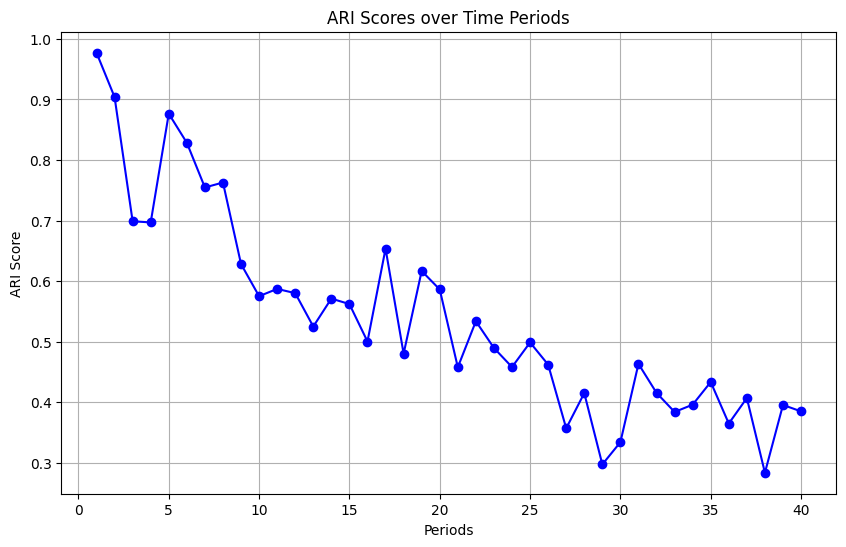

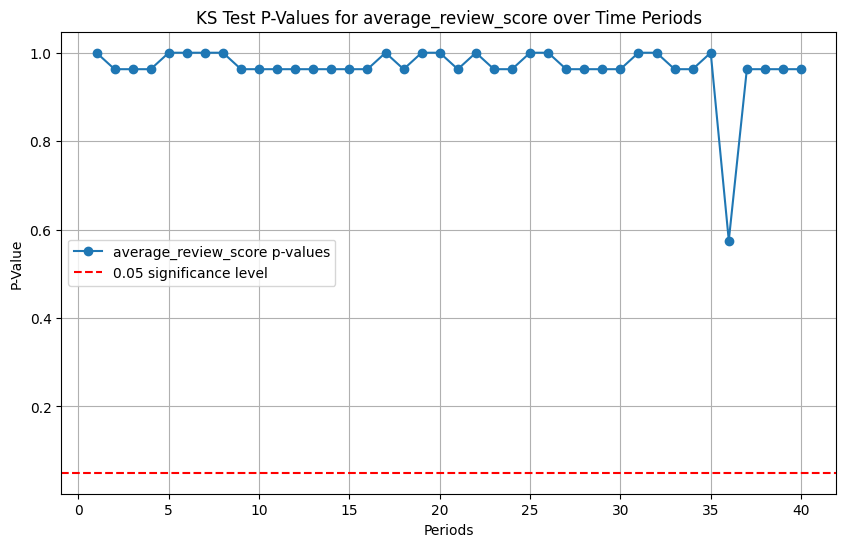

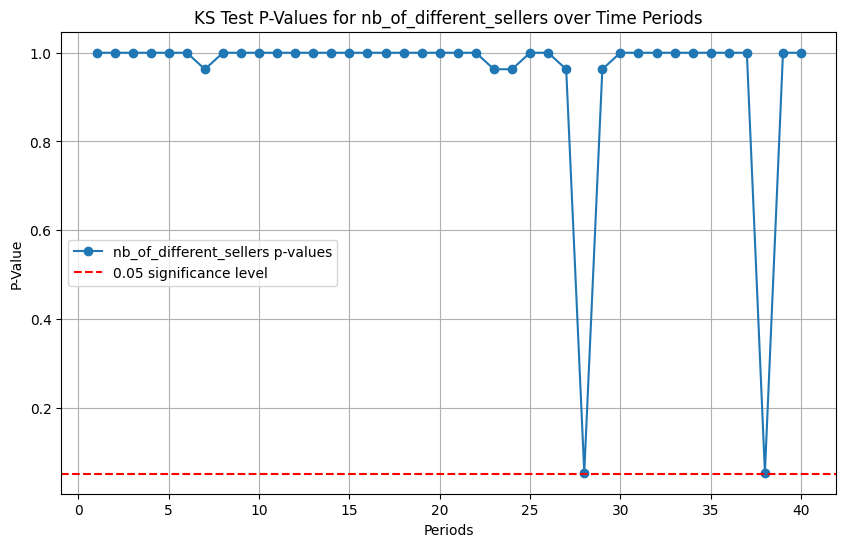

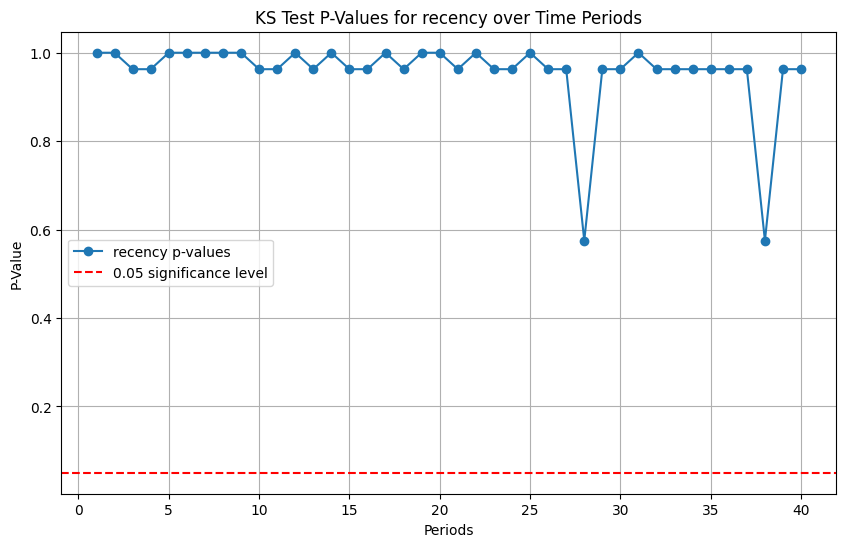

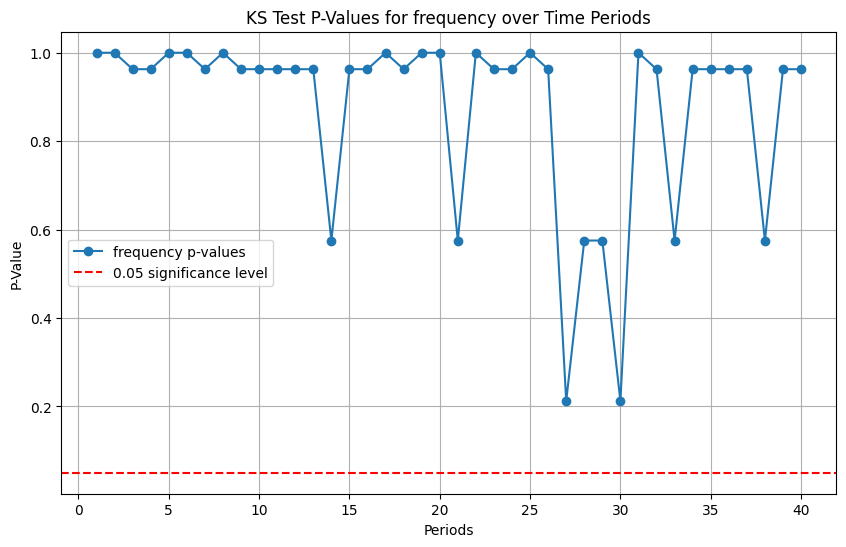

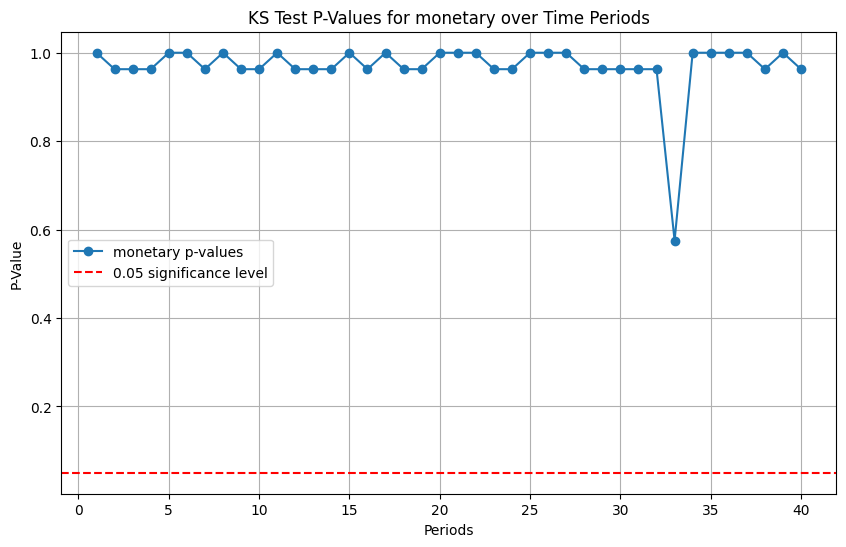

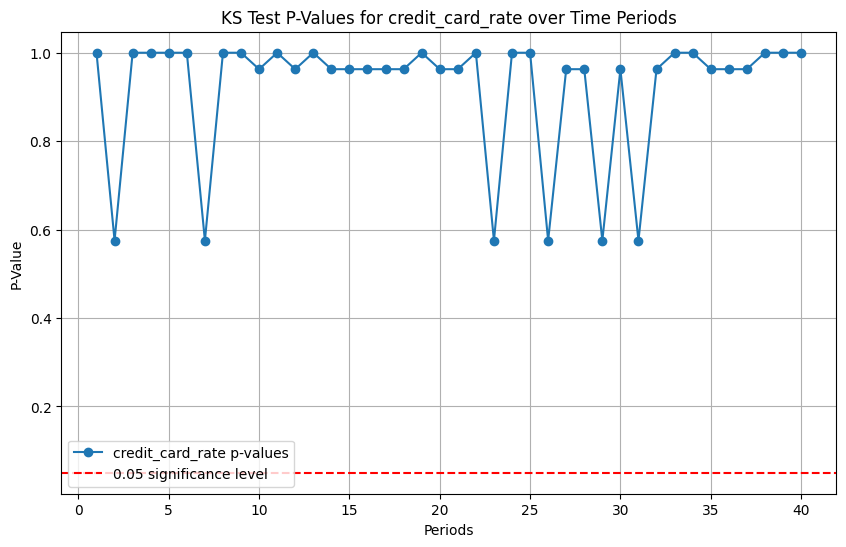

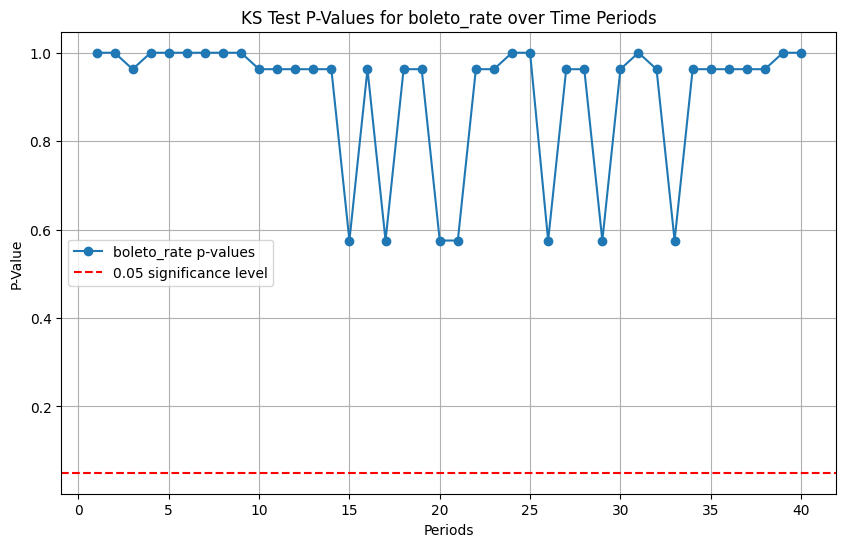

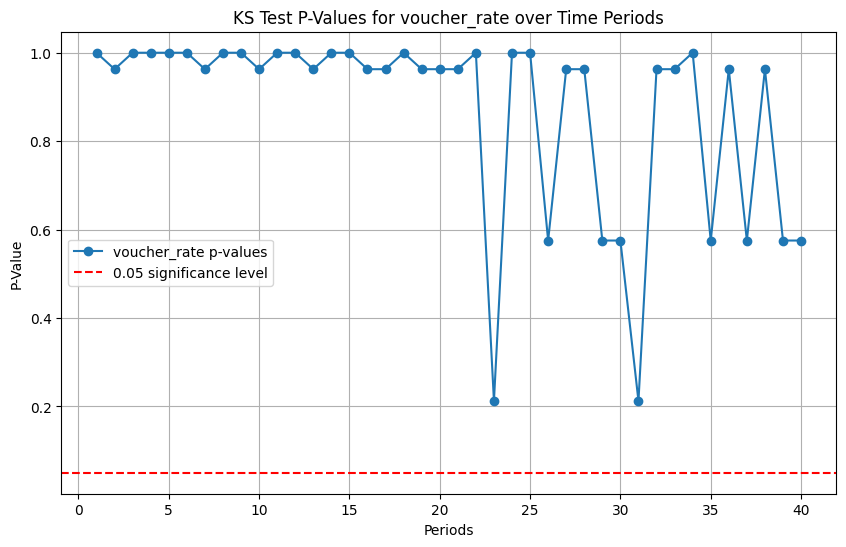

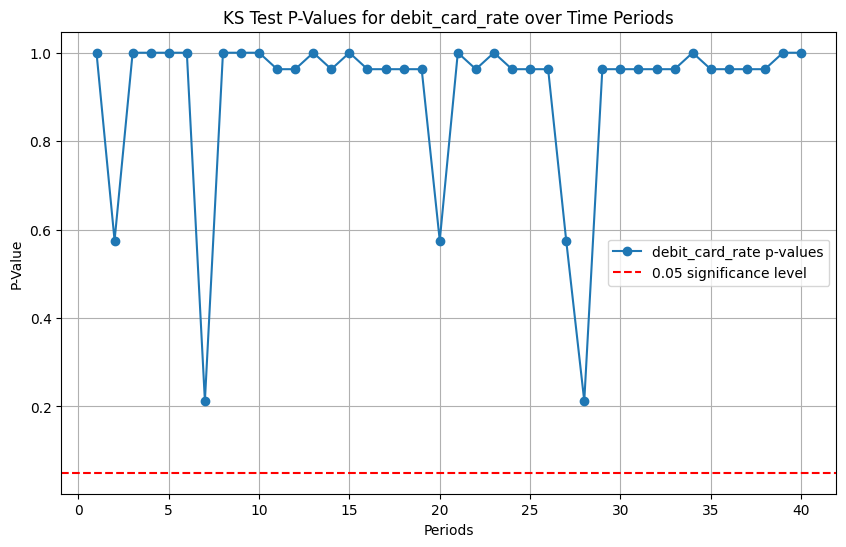

In [10]:
ari_scores, ks_p_values = eval_periods(grouped_dfs, ['average_review_score', 'nb_of_different_sellers', 'recency', 'frequency', 'monetary', 'credit_card_rate', 'boleto_rate', 'voucher_rate', 'debit_card_rate'], 7)
plot(ari_scores, ks_p_values)